In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
#from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
#from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
import shap
import time

In [2]:
#Dataframe erstellen in dem Ergebnisse gespeichert werden
#Spaltennamen definieren
columns_df = ["Modell", "Accuracy", "Precision", "Recall", "F1-Score", "AUC"]
#Leeren Dataframe erstellen
ergebnisse = pd.DataFrame(columns=columns_df)

In [15]:
#Daten einlesen
#Datensatz verwenden der mit One Hot Encoding umkodiert wurde
Full_Data = pd.read_csv('/home/RDC/petukhia.hub/H:/petukhia.hub/Masterarbeit_Dilara/LC_Data_Clean.csv',low_memory = False)

#Datenmenge reduzieren und jede zweite Zeile entfernen
Data = Full_Data.iloc[::2].reset_index(drop=True)



In [16]:
# Aufteilen der Daten in Features (X) und Zielvariable (y)
X = Data.drop('loan_status', axis=1) #Spalte loan Status entfernen
y = Data['loan_status'] #nur Spalte loan staus beibehalten

#Trainings und Test Datensatz erstellen
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 99)
#10% der Daten als Testdaten beibehalten

In [17]:
#Daten Scaling da die Spalten unterschiedliche Skalen haben
# Scaler für numerische Variablen initialisieren
scaler = StandardScaler()

###nummerische Trainingsdaten scalen###

#Numerische Variablen auswählen
#nummerische Spaltennamen werden zu einer Liste hinzugefügt
num_cols = ['loan_amnt', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 
            'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'acc_now_delinq', 'tot_coll_amt', 
            'acc_open_past_24mths', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt', 
            'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
            'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 
            'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 
            'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'pct_tl_nvr_dlq', 
            'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 
            'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'fico_average']
numerical_data_train = X_train[num_cols] #kategorische Spalten aus Datensatz entfernen
# Kategorische Variablen auswählen
categorical_data_train = X_train.drop(columns = num_cols) #Kategorische Spalten aus dem Trainingsdatensatz auswählen
# Index des ursprünglichen DataFrame speichern
index_train = numerical_data_train.index
# Scaler auf numerische Trainingsdaten anwenden
scaled_data_train = scaler.fit_transform(numerical_data_train)
# Skalierte numerische Daten in DataFrame zurückkonvertieren
X_train_scaled = pd.DataFrame(scaled_data_train, columns=num_cols, index= index_train)
# Skalierte numerische Daten und kategorische Daten wieder zusammenführen
X_train_scaled = pd.concat([X_train_scaled, categorical_data_train], axis=1)


#nummerische Testdaten scalen 
#Numerische Variablen auswählen
numerical_data_test = X_test[num_cols]
# Kategorische Variablen auswählen
categorical_data_test = X_test.drop(columns = num_cols)
# Index des ursprünglichen DataFrame speichern
index_test = numerical_data_test.index
# Scaler auf numerische Daten anwenden
scaled_data_test = scaler.transform(numerical_data_test) #nicht fit verwenden da auf Trainingsdaten gefittet wurde
# Skalierte numerische Daten in DataFrame zurückkonvertieren
X_test_scaled = pd.DataFrame(scaled_data_test, columns=num_cols, index= index_test)
# Skalierte numerische Daten und kategorische Daten wieder zusammenführen
X_test_scaled = pd.concat([X_test_scaled, categorical_data_test], axis=1)

In [1]:
#Anzahl an Beobachtungen reduzieren um Rechenzeit zu verringern mittels Undersampling
#Undersampling
print("Vor Undersampling:")
print("Anzahl Fully Paid:", sum(y_train==0)) #Anzahl an Beobachtungen mit "0" zählen
print("Anzahl Charged Off:", sum(y_train==1)) #Anzahl an Beobachtungen mit "1" zählen

# Random Undersampling
rus = RandomUnderSampler(random_state=42) #Algorithmus initialisieren
X_train_res, y_train_res = rus.fit_resample(X_train_scaled, y_train) #undersampler anwenden

#Ausgabe neuer Verteilung
print("\nNach Undersampling:")
print("Anzahl Fully Paid:", sum(y_train_res==0))
print("Anzahl Charged Off:", sum(y_train_res==1))

In [19]:
#vorläufige SVM 
svm = SVC(random_state = 42,probability = True) #support vector classifer modell
svm.fit (X_train_res, y_train_res) #Modell an Trainingsdaten fitten

modell = "Scaling + Undersampling"

#Genauigkeit vom Modell testen
accuracy = svm.score(X_test_scaled, y_test)
print(f"Genauigkeit auf den Testdaten: {accuracy}")

#Weitere Testmetriken berechnen

# Vorhersagen für die Testdaten berechnen
y_test_pred = svm.predict(X_test_scaled)
y_scores = svm.predict_proba(X_test_scaled)[:, 1]

#Testdaten
# Berechnung der Precision
precision_test = precision_score(y_test, y_test_pred)
print('Precision: ', precision_test)
# Berechnung des Recall
recall_test = recall_score(y_test, y_test_pred)
print('Recall: ', recall_test)
# Berechnung des F1-Scores
f1_test = f1_score(y_test, y_test_pred)
print('F1: ', f1_test)
#Berechnung AUC
auc = roc_auc_score(y_test, y_scores)
print('AUC: ', auc)

#Ergebnisse zum Dataframe hinzufügen
ergebnisse.loc[0] = [modell, accuracy, precision_test, recall_test, f1_test, auc]

Genauigkeit auf den Testdaten: 0.63
Precision:  0.26405867970660146
Recall:  0.6101694915254238
F1:  0.36860068259385664
AUC:  0.6807840956676346


In [8]:
# SVM-Modell initialisieren
#svm2 = SVC(random_state = 42,probability = True)

# Parameterraum festlegen
#param_grid = {
#    'C': [0.1, 1, 10, 100],  # Werte für C (Strafterm)
#    'gamma': [0.001, 0.01, 0.1, 1],  # Werte für gamma (Breite des Kernels)
#    'kernel': ['linear', 'rbf']  # Mögliche Kernel-Optionen
#}

# GridSearchCV initialisieren
#grid_search = GridSearchCV(
#    svm2,  # Vorher definiertes Modell
#    param_grid=param_grid,  # Vorher festgelegte Parameter
#    cv=5,  # 5-fache Kreuzvalidierung
#    n_jobs=-1  # Bestimmt, wie viele CPU-Kerne verwendet werden (-1 = alle verfügbaren Kerne)
#)

# GridSearchCV trainieren
#grid_search.fit(X_train_res, y_train_res)

# Beste Parameter und Modell ausgeben
#print("Beste Parameter:", grid_search.best_params_)
#print("Bester Score:", grid_search.best_score_)

# SVM-Modell mit den besten Parametern fitten
#svm2 = grid_search.best_estimator_
#svm2.fit(X_train_res, y_train_res)

In [20]:
# SVM-Modell initialisieren
svm2 = SVC(random_state = 42,probability = True)

#Parameterraum festlegen
param_distributions = {
    'C': uniform (1, 100), #Werte für C müssen > 0 ***Strafterm, uniform macht gleichmäßige kotinuierliche Verteilung
    'gamma': reciprocal(0.001, 0.1), #Breite des Kernels, reciprocal ist Verteilung bei der Logarithmus des Zufallswert gleichmäßig verteilt ist
    'kernel':['linear', 'rbf'] #Radio Basis Function liefert für üblich besten Werte
}

#RandomizedSearchCV initialisieren
random_search = RandomizedSearchCV(
    svm2, #vorher definiertes Mdoell
    param_distributions=param_distributions, #vorher festgelegte Parameter
    n_iter = 50, #Anzahl an verschiedenen Kombinationen die ausprobiert werden
    verbose = 2, #steuert Detailgrad der Ausgabe der Suche
    cv=5, #5-fache Kreuzvalidierung
    n_jobs = -1 #bestimmt wie viel CPU Kerne für Prozess verwendet werden ( -1 = alle verfügbaren)
)

#RandomSearchCV trainieren
random_search.fit(X_train_res, y_train_res)
#SVM trainieren
svm2.fit(X_train_res, y_train_res)

#Beste Paramete rund Modell ausgeben
print("Beste Parameter: ", random_search.best_params_)
print("Bester Score: ", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Beste Parameter:  {'C': 51.89951087070559, 'gamma': 0.0010240826523328047, 'kernel': 'rbf'}
Bester Score:  0.6377018988460573


In [21]:
modell2 = "Scaling + Undersampling +\nHyperparameter"

#Genauigkeit vom Modell testen
accuracy2 = svm2.score(X_test_scaled, y_test)
print(f"Genauigkeit auf den Testdaten: {accuracy2}")

#Weitere Testmetriken berechnen

# Vorhersagen für die Testdaten berechnen
y_test_pred2 = svm2.predict(X_test_scaled)
y_scores2 = svm2.predict_proba(X_test_scaled)[:, 1]

#Testdaten
# Berechnung der Precision
precision_test2 = precision_score(y_test, y_test_pred2)
print('Precision: ', precision_test2)
# Berechnung des Recall
recall_test2 = recall_score(y_test, y_test_pred2)
print('Recall: ', recall_test2)
# Berechnung des F1-Scores
f1_test2 = f1_score(y_test, y_test_pred2)
print('F1: ', f1_test2)
#Berechnung AUC
auc2 = roc_auc_score(y_test, y_scores2)
print('AUC: ', auc2)

#Ergebnisse zum Dataframe hinzufügen
ergebnisse.loc[1] = [modell2, accuracy2, precision_test2, recall_test2, f1_test2, auc2]

Genauigkeit auf den Testdaten: 0.63
Precision:  0.26405867970660146
Recall:  0.6101694915254238
F1:  0.36860068259385664
AUC:  0.6807840956676346


## Feature Selection
Feature reduzieren anhand von Lasso Regression bei LR

In [22]:
#Nur relevante Features behalten

#relevante Features
features = ['loan_amnt', 'dti', 'acc_open_past_24mths', 'mo_sin_old_rev_tl_op',
       'mort_acc', 'mths_since_recent_inq', 'tot_hi_cred_lim', 'fico_average',
       'emp_length', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified']
X_train_sel = X_train_res[features]
X_test_sel = X_test_scaled[features]

In [23]:
#SVM mit ausgwählten Features ohne Hyperparameter Optimierung
svm3 = SVC(random_state = 42,probability = True) #support vector classifer modell
svm3.fit (X_train_sel, y_train_res) #Modell an Trainingsdaten fitten
y_test_pred3 = svm3.predict(X_test_sel)#Modell trifft voraussagen
y_scores3 = svm3.predict_proba(X_test_sel)[:, 1]

modell3 = "Scaling + Undersampling +\nFeature Selection"
#Genauigkeit vom Modell testen
accuracy3 = svm3.score(X_test_sel, y_test)
print(f"Genauigkeit auf den Testdaten: {accuracy3}")

#Weitere Testmetriken berechnen

#Testdaten
# Berechnung der Precision
precision_test3 = precision_score(y_test, y_test_pred3)
print('Precision: ', precision_test)
# Berechnung des Recall
recall_test3 = recall_score(y_test, y_test_pred3)
print('Recall: ', recall_test3)
# Berechnung des F1-Scores
f1_test3 = f1_score(y_test, y_test_pred3)
print('F1: ', f1_test3)
#Berechnung AUC
auc3 = roc_auc_score(y_test, y_scores3)
print('AUC: ', auc3)

#Ergebnisse zum Dataframe hinzufügen
ergebnisse.loc[2] = [modell3, accuracy3, precision_test3, recall_test3, f1_test3, auc3]

Genauigkeit auf den Testdaten: 0.628
Precision:  0.26405867970660146
Recall:  0.6101694915254238
F1:  0.3673469387755102
AUC:  0.6612503518201976


In [ ]:
# SVM-Modell initialisieren
#svm4 = SVC(random_state = 42,probability = True)

# Parameterraum festlegen
#param_grid = {
#    'C': [0.1, 1, 10, 100],  # Werte für C (Strafterm)
#    'gamma': [0.001, 0.01, 0.1, 1],  # Werte für gamma (Breite des Kernels)
#    'kernel': ['linear', 'rbf']  # Mögliche Kernel-Optionen
#}

# GridSearchCV initialisieren
#grid_search2 = GridSearchCV(
#    svm4,  # Vorher definiertes Modell
#    param_grid=param_grid,  # Vorher festgelegte Parameter
#    cv=5,  # 5-fache Kreuzvalidierung
#    n_jobs=-1  # Bestimmt, wie viele CPU-Kerne verwendet werden (-1 = alle verfügbaren Kerne)
#)

# GridSearchCV trainieren
#grid_search2.fit(X_train_sel, y_train_res)

# Beste Parameter und Modell ausgeben
#print("Beste Parameter:", grid_search2.best_params_)
#print("Bester Score:", grid_search2.best_score_)

# SVM-Modell mit den besten Parametern fitten
#svm4 = grid_search2.best_estimator_
#svm4.fit(X_train_sel, y_train_res)

In [14]:
# SVM-Modell initialisieren
svm4 = SVC(random_state = 42,probability = True)

#Parameterraum festlegen
param_distributions = {
    'C': uniform (1, 100), #Werte für C müssen > 0 ***Strafterm, uniform macht gleichmäßige kotinuierliche Verteilung
    'gamma': reciprocal(0.001, 0.1), #Breite des Kernels, reciprocal ist Verteilung bei der Logarithmus des Zufallswert gleichmäßig verteilt ist
    'kernel':['linear', 'rbf'] #Radio Basis Function liefert für üblich besten Werte
}

#RandomizedSearchCV initialisieren
random_search2 = RandomizedSearchCV(
    svm4, #vorher definiertes Mdoell
    param_distributions=param_distributions, #vorher festgelegte Parameter
    n_iter = 50, #Anzahl an verschiedenen Kombinationen die ausprobiert werden
    verbose = 2, #steuert Detailgrad der Ausgabe der Suche
    cv=5, #5-fache Kreuzvalidierung
    n_jobs = -1 #bestimmt wie viel CPU Kerne für Prozess verwendet werden ( -1 = alle verfügbaren)
)

#RandomSearchCV trainieren
random_search2.fit(X_train_sel, y_train_res)

# Startzeit messen
start_time = time.time()
#SVM trainieren
svm4.fit(X_train_sel, y_train_res)
# Endzeit messen
end_time = time.time()

#Beste Paramete rund Modell ausgeben
print("Beste Parameter: ", random_search2.best_params_)
print("Bester Score: ", random_search2.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Beste Parameter:  {'C': 6.119150813335072, 'gamma': 0.0022216051614549538, 'kernel': 'rbf'}
Bester Score:  0.5769230769230769


In [15]:
modell4 = "Scaling + Undersampling +\nFeature Selection + Hyperparamter"

#Genauigkeit vom Modell testen
accuracy4 = svm4.score(X_test_sel, y_test)
print(f"Genauigkeit auf den Testdaten: {accuracy4}")

#Weitere Testmetriken berechnen

# Vorhersagen für die Testdaten berechnen
y_test_pred4 = svm4.predict(X_test_sel)
y_scores4 = svm4.predict_proba(X_test_sel)[:, 1]

#Testdaten
# Berechnung der Precision
precision_test4 = precision_score(y_test, y_test_pred4)
print('Precision: ', precision_test4)
# Berechnung des Recall
recall_test4 = recall_score(y_test, y_test_pred4)
print('Recall: ', recall_test4)
# Berechnung des F1-Scores
f1_test4 = f1_score(y_test, y_test_pred4)
print('F1: ', f1_test4)
#Berechnung AUC
auc4 = roc_auc_score(y_test, y_scores4)
print('AUC: ', auc4)

# Gesamtrechenzeit berechnen und ausgeben
elapsed_time = end_time - start_time
print(f"Gesamtrechenzeit: {elapsed_time} Sekunden")

#Ergebnisse zum Dataframe hinzufügen
ergebnisse.loc[3] = [modell4, accuracy4, precision_test4, recall_test4, f1_test4, auc4]

Genauigkeit auf den Testdaten: 0.48
Precision:  0.07407407407407407
Recall:  0.6666666666666666
F1:  0.13333333333333333
AUC:  0.326241134751773
Gesamtrechenzeit: 0.011395692825317383 Sekunden


Text(0.5, 1.0, 'Confusion Matrix für Selected Features')

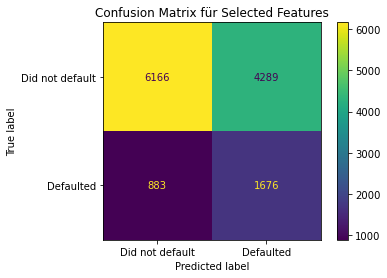

In [10]:
#Confusion Matrix berechnen
cm2 = confusion_matrix(y_test, y_test_pred3, labels=svm4.classes_) #confusionmatrix für Testdaten berecnen
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, #Confusion Matrix plotten
                               display_labels=["Did not default", "Defaulted"]) #Labels beschriften

disp.plot()
plt.title('Confusion Matrix für Selected Features') #Überschrift festlegen

AUC:  0.6714501513679366


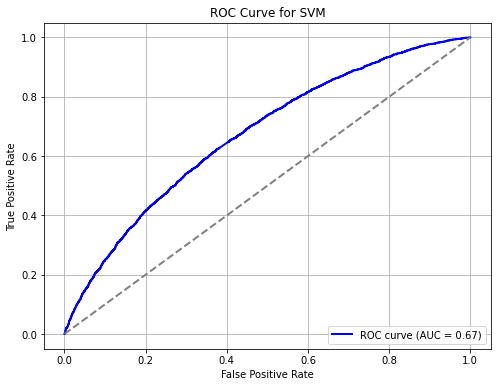

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores4)

print('AUC: ', auc4)

# ROC-Kurve plotten
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {auc4:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

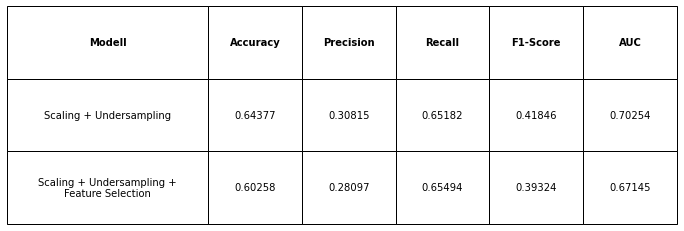

In [12]:
# Numerische Spalten auf 5 Nachkommastellen begrenzen
numerical_cols = ergebnisse.select_dtypes(include=['float64']).columns
ergebnisse[numerical_cols] = ergebnisse[numerical_cols].round(5)

# Tabelle erstellen
fig, ax = plt.subplots(figsize=(12, 4))  # Figur und Achsen erstellen
ax.axis('off')  # Achsen ausschalten

# Spaltenbreiten festlegen
col_widths = [0.3] + [0.14 for _ in range(ergebnisse.shape[1] - 1)]

# Tabellendiagramm erstellen
table = ax.table(cellText=ergebnisse.values, colLabels=ergebnisse.columns, cellLoc='center', loc='center', bbox=[0, 0, 1, 1], colWidths=col_widths)

# Überschriften fett drucken
table.auto_set_font_size(False)
table.set_fontsize(10)  # Schriftgröße anpassen, falls gewünscht
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_text_props(fontweight='bold')  # Überschrift fett drucken

plt.show()

## Modell erklären 

In [ ]:
#Feature Importance ausgeben lassen
svm4.coef_